# Bank Churn Modeling

### Table of Contents:
1) Feature Selection
2) Feature Correlation
3) Models

### 1) Feature Selection

In [1]:
# Setup using Edwin's code
import numpy as np
import pandas as pd
import datetime as dt
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#-10000000000.0 needs to be dropped
outliers = c_df[(c_df['start_balance'] <= -100000.0)]
c_df = c_df.drop(outliers.index)

In [2]:
c_df_original = pd.read_csv(r"C:\bank-churn-data\customers_tm1_e.csv")
c_df_original['start_balance'] = c_df_original['start_balance'].apply(lambda x: 0 if pd.isna(x) else x)
c_df_original.loc[c_df_original['start_balance'] < 0,'start_balance'] = 0
c_df_original.loc[c_df_original['start_balance'] >10000000,'start_balance'] = 0
c_df = c_df_original[:1000]
c_array = c_df.to_numpy()

# Convert customer data to transactional rows
c_to_t = pd.DataFrame()
c_to_t['date'] = c_df_original['creation_date']
c_to_t['account_id'] = 0
c_to_t['customer_id'] = c_df_original['customer_id']
c_to_t['amount'] = c_df_original['start_balance']
c_to_t['transaction_date'] = c_df_original['creation_date']
c_to_t['deposit'] = c_df_original['start_balance']#.apply(lambda x: 0 if pd.isna(x) else x)
c_to_t['withdrawal'] = 0

# Load transactional dataset
t_df_original = pd.read_csv(r"C:\bank-churn-data\transactions_tm1_e.csv")
t_df_original = pd.concat([c_to_t, t_df_original])
t_df = t_df_original.iloc[:1000]
t_array = t_df.to_numpy()

In [3]:
# Edwin's code
t_df_original['transaction_date'] = t_df_original['transaction_date'].apply(pd.to_datetime)
t_df_original = t_df_original.sort_values(by=['customer_id', 'transaction_date'])
t_df_original['month'] = t_df_original['transaction_date'].dt.month
t_df_original['year'] = t_df_original['transaction_date'].dt.year
t_df_original['deposit_y'] = t_df_original['deposit'].apply(lambda x: 1 if abs(x) > 0 else 0)
t_df_original['withdrawal_y'] = t_df_original['withdrawal'].apply(lambda x: 1 if abs(x) > 0 else 0)
t_df_original['checked_balance'] = t_df_original['amount'].apply(lambda x: 1 if abs(x) == 0 else 0)
t_df_original['time_since_last_trans'] = t_df_original.groupby('customer_id')['transaction_date'].diff()
t_df_original['time_since_last_trans_in_days'] = t_df_original['time_since_last_trans'].dt.total_seconds()/(60*60*24)

KeyboardInterrupt: 

In [10]:
## Griffen's reworking of Edwin's code
t_df_original['transaction_date'] = pd.to_datetime(t_df_original['transaction_date'])
t_df_original = t_df_original.sort_values(by=['customer_id', 'transaction_date'])
t_df_original['month'] = t_df_original['transaction_date'].dt.month
t_df_original['year'] = t_df_original['transaction_date'].dt.year
t_df_original['deposit_y'] = (t_df_original['deposit'].abs() > 0).astype(int)
t_df_original['withdrawal_y'] = (t_df_original['withdrawal'].abs() > 0).astype(int)
t_df_original['checked_balance'] = (t_df_original['amount'].abs() == 0).astype(int)
t_df_original['time_since_last_trans'] = t_df_original.groupby('customer_id')['transaction_date'].diff()
t_df_original['time_since_last_trans_in_days'] = t_df_original['time_since_last_trans'].dt.total_seconds()/(60*60*24)
t_df_original['running_balance'] = t_df_original.groupby('customer_id')['amount'].cumsum()

temp_df = t_df_original.groupby('customer_id').agg(last_date=('transaction_date','max'))
t_df_original = t_df_original.merge(temp_df, how='inner', on='customer_id')
t_df_original['3m_mark'] = t_df_original['last_date'] + pd.Timedelta(-91, 'd')
t_df_original['last_3_months'] = (t_df_original['transaction_date'] >=
                                  t_df_original['3m_mark']
                                  ).replace({True:1, False:0})
t_df_original = t_df_original.drop(columns=[ '3m_mark', 'last_date'])

display(t_df_original)


,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal,month,year,deposit_y,withdrawal_y,checked_balance,time_since_last_trans,time_since_last_trans_in_days,last_3_months,running_balance
0,2007-01-31,24137947,91,-5295.18,2007-01-16,0.00,-5295.18,1,2007,0,1,0,NaT,NaN,1,-5295.18
1,2007-01-31,0,91,10180.56,2007-01-31,10180.56,0.00,1,2007,1,0,0,15 days,15.0,1,4885.38
2,2007-01-31,24137947,91,3034.26,2007-01-31,3034.26,0.00,1,2007,1,0,0,0 days,0.0,1,7919.64
3,2007-02-28,24137947,91,0.00,2007-02-28,0.00,0.00,2,2007,0,0,1,28 days,28.0,1,7919.64
4,2007-03-31,24137947,91,-0.00,2007-03-11,0.00,-0.00,3,2007,0,0,1,11 days,11.0,1,7919.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093983,2020-05-31,24253960,116104,2900.20,2020-05-31,2900.20,0.00,5,2020,1,0,0,0 days,0.0,1,9909.26
5093984,2020-05-31,0,116105,8861.08,2020-05-31,8861.08,0.00,5,2020,1,0,0,NaT,NaN,1,8861.08
5093985,2020-05-31,24253961,116105,2246.93,2020-05-31,2246.93,0.00,5,2020,1,0,0,0 days,0.0,1,11108.01
5093986,2020-05-31,0,116106,201.32,2020-05-31,201.32,0.00,5,2020,1,0,0,NaT,NaN,1,201.32


In [11]:
t_df_grouped = t_df_original.groupby(
    ["customer_id","year","month"])['amount','deposit','withdrawal', 'deposit_y','withdrawal_y',
                                    'time_since_last_trans_in_days', 'checked_balance'].agg(
    sum_deposit = ("deposit","sum"),
    sum_withdrawal = ("withdrawal","sum"),
    count_deposit = ("deposit_y", "sum"),
    count_withdrawal = ("withdrawal_y", 'sum'),
    checked_balance = ("checked_balance",'max'),
    mean_time_between_trans = ("time_since_last_trans_in_days", "mean")
)

t_df_grouped['sum_delta'] = t_df_grouped['sum_deposit'] + t_df_grouped['sum_withdrawal']
t_df_grouped['mean_deposit'] = (
    t_df_grouped['sum_deposit']/t_df_grouped['count_deposit'].apply(lambda x:max(1,x)))
t_df_grouped['mean_withdrawal'] = (
    t_df_grouped['sum_withdrawal']/t_df_grouped['count_withdrawal'].apply(lambda x:max(1,x)))

t_df_grouped['running_balance'] = t_df_grouped.groupby('customer_id')['sum_delta'].cumsum()


C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_32980\250260605.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t_df_grouped = t_df_original.groupby(


In [12]:
c_combined = t_df_original.groupby(
    "customer_id")[['deposit','withdrawal', 'deposit_y', 'withdrawal_y','checked_balance',
                   'transaction_date','time_since_last_trans_in_days', 'last_3_months']].agg(
    total_deposits = ("deposit","sum"),
    total_withdrawals = ("withdrawal","sum"),
    num_deposit = ("deposit_y", "sum"),
    num_withdrawal = ("withdrawal_y", 'sum'),
    num_checked_balance = ("checked_balance",'max'),
    num_transactions = ('deposit','count'),
    first_transaction = ('transaction_date','first'),
    last_transaction = ('transaction_date','last'),
    mean_time_between_trans_in_days = ('time_since_last_trans_in_days','mean'),
    transactions_during_last_3m = ('last_3_months', 'sum')
                   )

#c_summary['final_balance'] = c_summary['total_deposits'] + c_summary['total_withdrawals']
# act_lifespan - lifespan of account, time from first transaction to last transaction
c_summary['act_lifespan_in_days'] = c_summary['last_transaction'] - c_summary['first_transaction']
c_summary['act_lifespan_in_days'] = c_summary['act_lifespan_in_days'].dt.total_seconds()/(60*60*24) + 1
# time_since_last_trans - time between 2020-06-01 (end of data window) and last transaction of customer
c_summary['time_since_last_trans_in_days'] = pd.to_datetime('2020-06-01') - c_summary['last_transaction']
c_summary['time_since_last_trans_in_days'] = c_summary['time_since_last_trans_in_days'].dt.total_seconds()/(60*60*24)
c_summary['transactional_rate_lifetime'] = c_summary['num_transactions']/c_summary['act_lifespan_in_days']
# Features for last 3 months
c_summary['t_rate_last_3m'] = c_summary['transactions_during_last_3m']/91
c_summary['t_rate_last_3m_over_lifetime']= c_summary['t_rate_last_3m']/c_summary['transactional_rate_lifetime']
c_summary['t_in_last_3m'] = (c_summary['last_transaction'] > (pd.to_datetime('2020-06-01') + pd.Timedelta(-91,"d"))).replace(
    {True:1,False:0})
c_summary = c_summary.reset_index()

last_3m_balances = t_df_original[t_df_original['last_3_months'] == 1].groupby(
    'customer_id')[['amount', 'running_balance']].agg(
        first_amount_of_3m = ('amount', 'first'),
        first_rb_of_3m = ('running_balance', 'first'),
        final_balance = ('running_balance', 'last')
    )
last_3m_balances = last_3m_balances.reset_index()
last_3m_balances['delta_last_3m'] = (last_3m_balances['final_balance']
                                        + last_3m_balances['first_amount_of_3m']
                                        - last_3m_balances['first_rb_of_3m'])
last_3m_balances['saved_last_3m'] = (last_3m_balances['delta_last_3m'] > 0).replace({True: 1, False:0})
c_summary = c_summary.merge(last_3m_balances[['customer_id', 'delta_last_3m',
                                              'saved_last_3m', 'final_balance']],
                            how='inner', on='customer_id')

# Creating full dataframe summarizing customer features
c_combined = c_df_original.merge(c_summary, how='inner', on='customer_id')
c_combined['age_at_last_trans'] = c_combined['last_transaction'] - c_combined['dob'].apply(pd.to_datetime)
c_combined['age_at_last_trans'] = c_combined['age_at_last_trans'].dt.total_seconds()/(60*60*24*365)
c_combined['churned'] = (c_combined['last_transaction'] <= pd.to_datetime('2019-12-01')).replace({True:1, False:0})


display(c_combined)


,customer_id,dob,state,start_balance,creation_date,total_deposits,total_withdrawals,num_deposit,num_withdrawal,num_checked_balance,...,time_since_last_trans_in_days,transactional_rate_lifetime,t_rate_last_3m,t_rate_last_3m_over_lifetime,t_in_last_3m,delta_last_3m,saved_last_3m,final_balance,age_at_last_trans,churned
0,91,1993-07-01,California,10180.56,2007-01-31,13214.82,-5295.18,2,1,1,...,4812.0,0.094595,0.076923,0.813187,0,7919.64,1,7919.64,13.753425,1
1,92,1985-12-05,New York,4757.68,2007-01-31,18049.77,-7629.15,11,16,1,...,4462.0,0.078240,0.043956,0.561813,0,1418.64,1,10420.62,22.287671,1
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,26619.33,-18965.15,11,19,0,...,4567.0,0.098684,0.131868,1.336264,0,-3202.50,0,7654.18,20.043836,1
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,27674.87,-16791.91,7,18,1,...,4597.0,0.111842,0.043956,0.393019,0,0.00,0,10882.96,26.624658,1
4,95,1970-04-06,California,12500.72,2007-01-31,73832.84,-48886.87,18,26,1,...,4292.0,0.082902,0.032967,0.397665,0,3544.79,1,24945.97,38.430137,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116011,116102,1969-03-02,Georgia,3110.96,2020-05-31,3983.95,-1223.94,2,1,0,...,1.0,0.150000,0.032967,0.219780,1,2760.01,1,2760.01,51.282192,0
116012,116103,1966-10-25,New York,12063.92,2020-05-31,15418.32,-4357.62,2,2,0,...,1.0,0.173913,0.043956,0.252747,1,11060.70,1,11060.70,53.635616,0
116013,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,13911.56,-4002.30,2,1,0,...,1.0,1.000000,0.032967,0.032967,1,9909.26,1,9909.26,34.109589,0
116014,116105,1983-08-25,New Mexico,8861.08,2020-05-31,11108.01,0.00,2,0,0,...,1.0,2.000000,0.021978,0.010989,1,11108.01,1,11108.01,36.791781,0


In [10]:
# Create response variable (labeling)
last_date = pd.to_datetime('2019-12-31')
c_summary['churn'] = np.where(c_summary['last_transaction'] < last_date,1,0)

In [13]:
# Load in fed funds rate data
ir_df = pd.read_csv(r"C:\bank-churn-data\FEDFUNDS.csv")
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])
ir_df['month'] = ir_df['DATE'].dt.month
ir_df['year'] = ir_df['DATE'].dt.year

In [15]:
# Merge with c_summary. Create feature that is interest rate at last transaction date.
c_combined['last_trans_month'] = c_combined['last_transaction'].dt.month
c_combined['last_trans_year'] = c_combined['last_transaction'].dt.year
c_combined = pd.merge(c_combined, ir_df, left_on=['last_trans_month', 'last_trans_year'], right_on=['month','year'])


In [17]:
c_combined = c_combined.drop(['DATE','month','year'],axis=1)

In [15]:
# create net_total_trans column
c_combined['net_total_trans'] = c_combined['total_deposits'] + c_combined['total_withdrawals']

In [16]:
# get age of customers from c_df
c_summary = pd.merge(c_summary, c_df_original[['customer_id','dob']], on=['customer_id'])
c_summary['dob'] = pd.to_datetime(c_summary['dob'])
c_summary['age_at_last_trans'] = ((c_summary['last_transaction'] - c_summary['dob'])/np.timedelta64(1, 'Y')).astype(int)

In [17]:
## normalize deposit total and withdrawal total and take ratio

# c_summary['total_deposits_normalized'] = (c_summary['total_deposits'] - c_summary['total_deposits'].min()) /(c_summary['total_deposits'].max() - c_summary['total_deposits'].min())
# c_summary['total_withdrawals_pos'] = c_summary['total_withdrawals'] *-1
# c_summary['total_withdrawals_normalized'] = (c_summary['total_withdrawals_pos'] - c_summary['total_withdrawals_pos'].min()) /(c_summary['total_withdrawals_pos'].max() - c_summary['total_withdrawals_pos'].min())
# c_summary['d_w_normalized_ratio'] =  c_summary['total_withdrawals_normalized']/ c_summary['total_deposits_normalized'] 

In [19]:
display(c_combined)

,customer_id,dob,state,start_balance,creation_date,total_deposits,total_withdrawals,num_deposit,num_withdrawal,num_checked_balance,...,t_rate_last_3m_over_lifetime,t_in_last_3m,delta_last_3m,saved_last_3m,final_balance,age_at_last_trans,churned,last_trans_month,last_trans_year,FEDFUNDS
0,91,1993-07-01,California,10180.56,2007-01-31,13214.82,-5295.18,2,1,1,...,0.813187,0,7919.64,1,7919.64,13.753425,1,3,2007,5.26
1,115,1987-10-20,Texas,3604.64,2007-01-31,4528.27,-1442.37,2,4,1,...,0.890110,0,3085.90,1,3085.90,19.452055,1,3,2007,5.26
2,121,1992-03-31,California,5405.44,2007-01-31,5405.44,0.00,1,0,1,...,0.670330,0,5405.44,1,5405.44,15.008219,1,3,2007,5.26
3,132,1992-06-09,Louisiana,5895.44,2007-01-31,11255.58,-9821.09,4,7,0,...,0.736264,0,1434.49,1,1434.49,14.816438,1,3,2007,5.26
4,183,1982-12-22,Ohio,6619.88,2007-01-31,12220.79,-8641.39,4,7,0,...,0.923077,0,3579.40,1,3579.40,24.287671,1,3,2007,5.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116011,112212,1987-08-22,California,139.28,2020-01-31,139.28,0.00,1,0,1,...,0.087912,0,139.28,1,139.28,32.465753,0,1,2020,1.55
116012,112325,1984-12-03,North Carolina,5973.36,2020-01-31,7728.41,-3325.03,2,2,0,...,0.285714,0,4403.38,1,4403.38,35.183562,0,1,2020,1.55
116013,112330,1992-04-12,California,0.64,2020-01-31,0.84,-0.37,2,1,0,...,0.142857,0,0.47,1,0.47,27.821918,0,1,2020,1.55
116014,112405,1951-02-07,Texas,9742.72,2020-01-31,12697.62,0.00,2,0,0,...,0.010989,0,12697.62,1,12697.62,69.027397,0,1,2020,1.55


In [24]:
## Take squares of mean_time_between_trans_in_days, final_balance, time_since_last_trans_in_days,
# transactional_rate, FEDFUNDS, net_total_trans

# print(c_summary.columns.values)
# c_summary['time_between_trans**2'] = c_summary['mean_time_between_trans_in_days'] ** 2
# c_summary['final_bal**2'] = c_summary['final_balance'] ** 2
# c_summary['trans_rate**2'] = c_summary['transactional_rate'] ** 2
# c_summary['fed_funds**2'] = c_summary['FEDFUNDS'] ** 2
# c_summary['net_total_trans**2'] = c_summary['net_total_trans'] ** 2


['customer_id' 'total_deposits' 'total_withdrawals' 'num_deposit'
 'num_withdrawal' 'num_checked_balance' 'num_transactions'
 'first_transaction' 'last_transaction' 'mean_time_between_trans_in_days'
 'final_balance' 'act_lifespan_in_days' 'time_since_last_trans_in_days'
 'transactional_rate' 'churn' 'last_trans_month' 'last_trans_year'
 'FEDFUNDS' 'net_total_trans' 'dob' 'age_at_last_trans'
 'total_deposits_normalized' 'total_withdrawals_pos'
 'total_withdrawals_normalized' 'd_w_normalized_ratio']


In [14]:
# get list of all data frames in memory
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs) # need to use c_summary, t_df_original, fedfunds, t_df_grouped
# note that we are missing state in c_summary

['c_df', 'c_df_original', 'c_summary', 'c_to_t', 'ir_df', 't_df', 't_df_grouped', 't_df_original']


#### Features for model:
- State dummies
- Age of customer at last transaction date 
- time_since_last_trans_in_days (done)
- mean_time_between_trans_in_days (done)
- act_lifespan_in_days (done)
- Net transaction amount: total_deposits + total_withdrawals (done)
- Interest rate (done)
- Inflation rate (maybe)
- Whether they have had a transaction for last 3 months
- Whether their ending balance was positive for last 3 months
- Ratio of deposits to withdrawals (done-ish)


#### New features:
- Square random things, also maybe log of some things
- transaction_rate for last 3 months of activity/ average transactional rate over entire account lifespan
- Normalized deposit amounts / normalized withdrawal amounts

In [27]:
pd.set_option('display.max_columns', None)
print(c_summary.corr())

C:\Users\GriffenRoweGaddis\AppData\Local\Temp\ipykernel_27236\796146733.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(c_summary.corr())


                                 customer_id  total_deposits  \
customer_id                         1.000000       -0.081023   
total_deposits                     -0.081023        1.000000   
total_withdrawals                   0.084973       -0.976850   
num_deposit                        -0.109250        0.719420   
num_withdrawal                     -0.101527        0.676327   
num_checked_balance                -0.078414        0.239609   
num_transactions                   -0.112170        0.703466   
mean_time_between_trans_in_days    -0.059122        0.159158   
final_balance                      -0.027861        0.610140   
act_lifespan_in_days               -0.111121        0.714464   
time_since_last_trans_in_days      -0.930066       -0.174920   
transactional_rate                  0.090438       -0.133202   
churn                              -0.575340       -0.135108   
last_trans_month                   -0.097367       -0.017319   
last_trans_year                     0.92

In [20]:
print(c_combined.columns.values)

['customer_id' 'dob' 'state' 'start_balance' 'creation_date'
 'total_deposits' 'total_withdrawals' 'num_deposit' 'num_withdrawal'
 'num_checked_balance' 'num_transactions' 'first_transaction'
 'last_transaction' 'mean_time_between_trans_in_days'
 'transactions_during_last_3m' 'act_lifespan_in_days'
 'time_since_last_trans_in_days' 'transactional_rate_lifetime'
 't_rate_last_3m' 't_rate_last_3m_over_lifetime' 't_in_last_3m'
 'delta_last_3m' 'saved_last_3m' 'final_balance' 'age_at_last_trans'
 'churned' 'last_trans_month' 'last_trans_year' 'FEDFUNDS']


Text(0.5, 1.0, 'Correlation Heatmap')

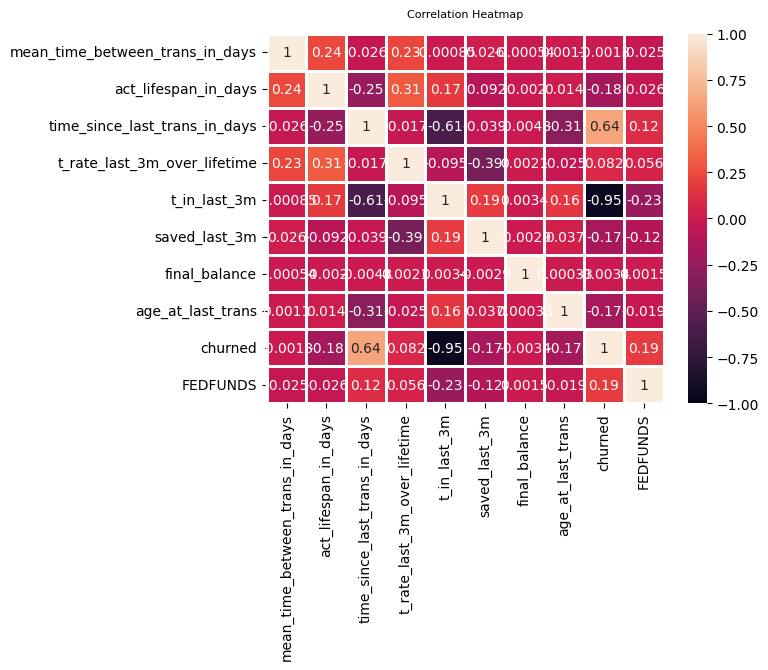

In [28]:
# c_summary correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the columns
selected_columns = [
                    'mean_time_between_trans_in_days',
                    'act_lifespan_in_days', 'time_since_last_trans_in_days', 't_rate_last_3m_over_lifetime', 't_in_last_3m',
                    'saved_last_3m', 'final_balance', 'age_at_last_trans',
                    'churned', 'FEDFUNDS']

# Subset the DataFrame with the selected columns
subset_df = c_combined[selected_columns]

# Calculate correlation matrix
heatmap = sns.heatmap(subset_df.corr(),vmin=-1, vmax=1, annot=True, linewidths=1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=12)

array([[<AxesSubplot: title={'center': 'act_lifespan_in_days'}>,
        <AxesSubplot: title={'center': 'FEDFUNDS'}>],
       [<AxesSubplot: title={'center': 'age_at_last_trans'}>,
        <AxesSubplot: title={'center': 't_in_last_3m'}>],
       [<AxesSubplot: title={'center': 'saved_last_3m'}>,
        <AxesSubplot: >]], dtype=object)

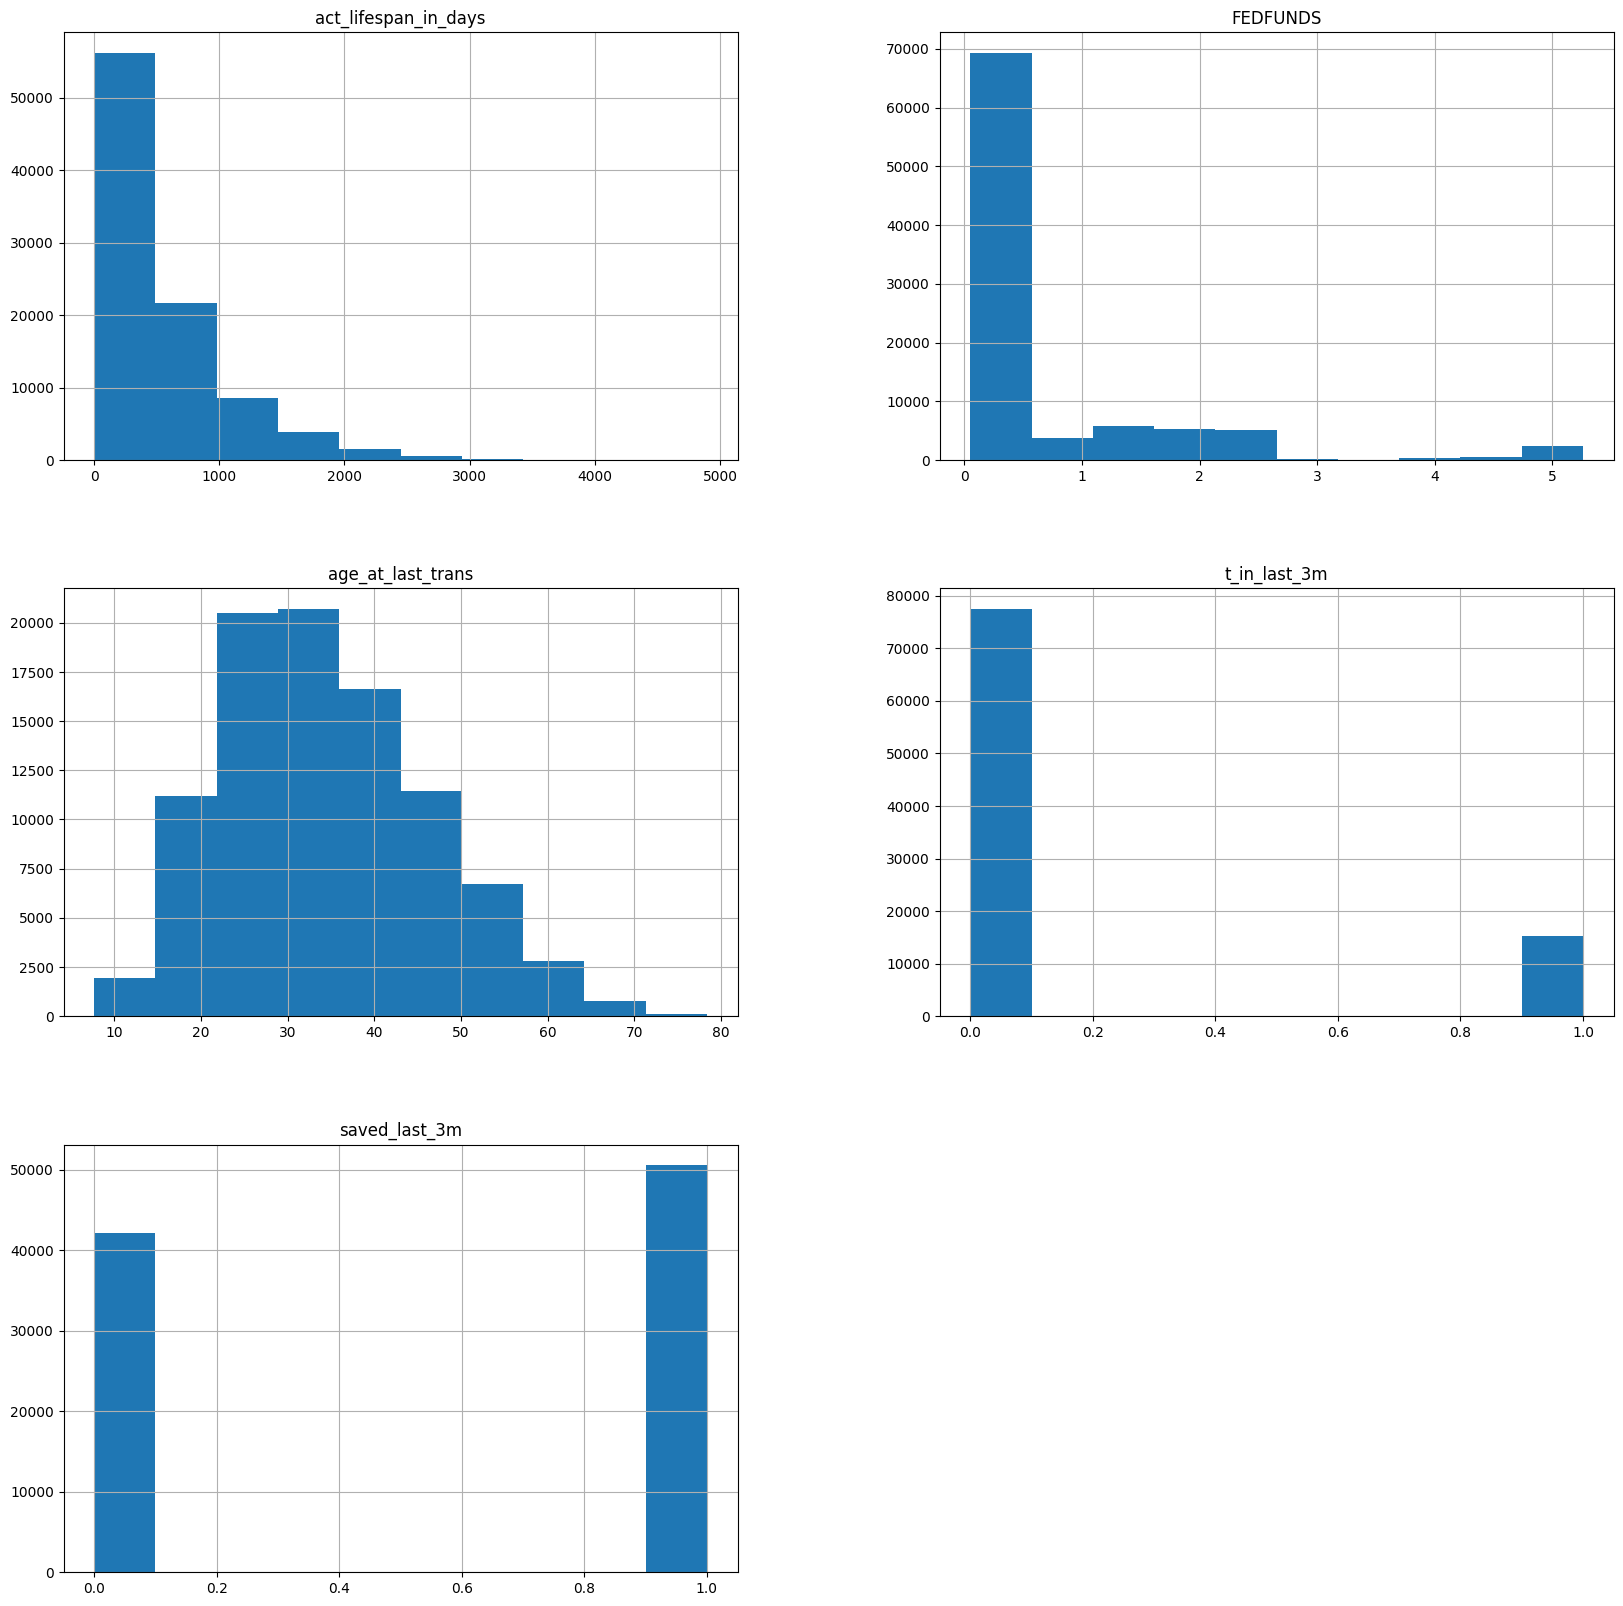

In [43]:
X_train.hist(figsize=(20,20))

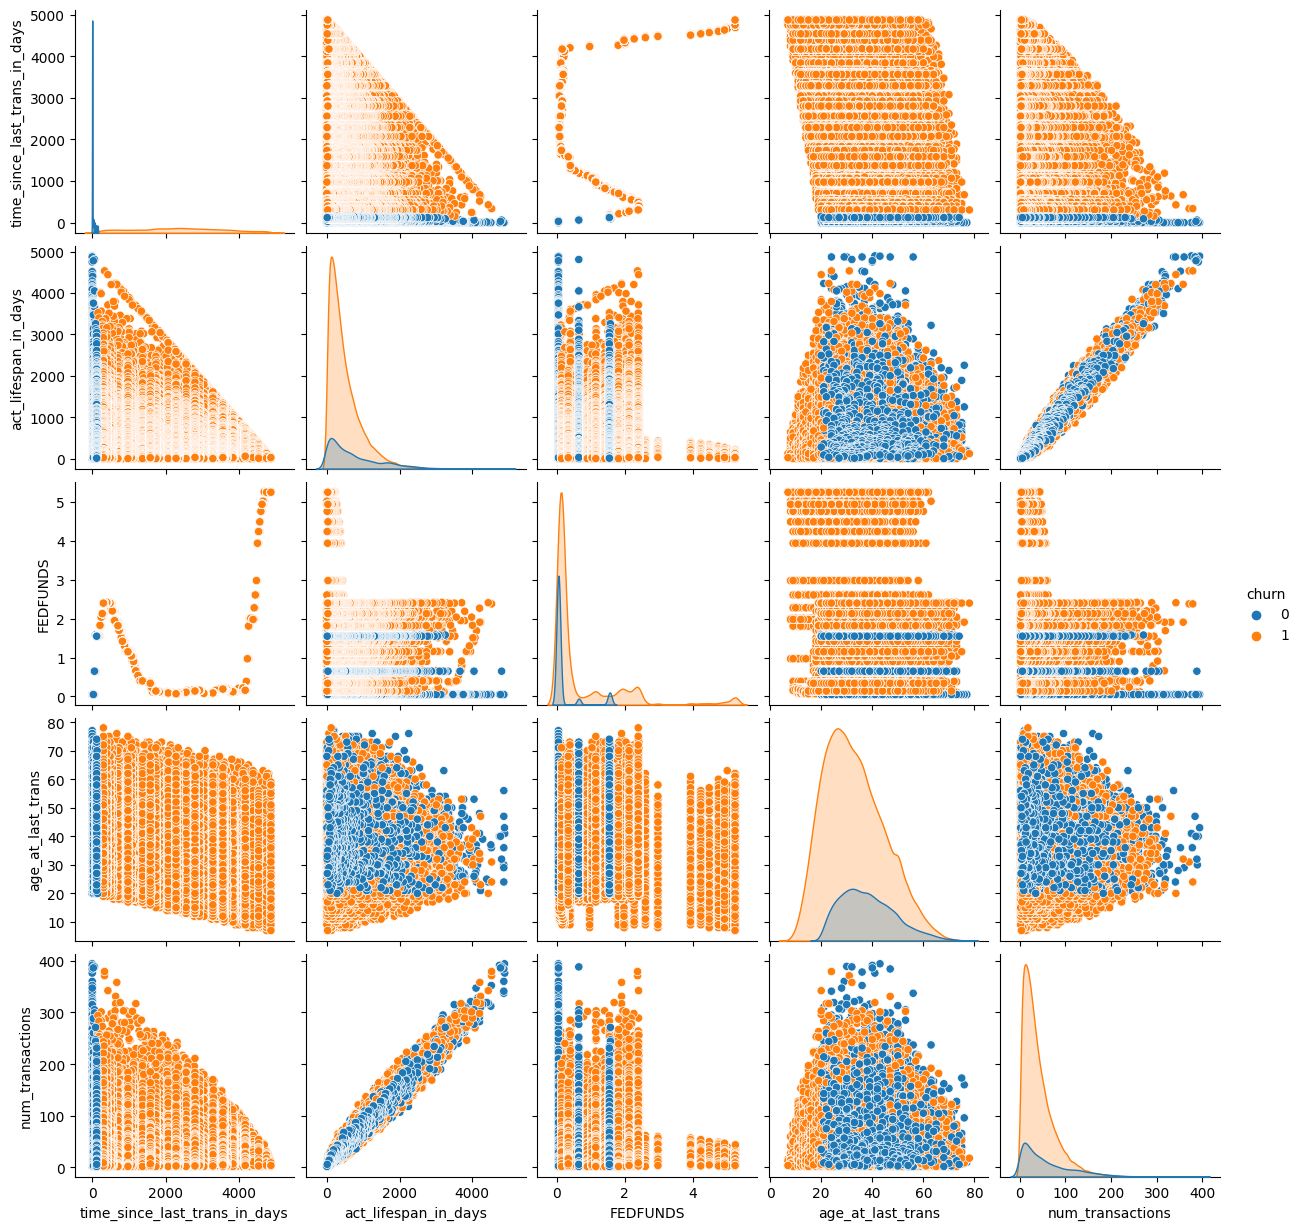

In [40]:
c_summ_features = c_summary[['act_lifespan_in_days','FEDFUNDS','age_at_last_trans','num_transactions','churn']]
p=sns.pairplot(c_summ_features, hue='churn')


### Models
- Logistic Regression
- LDA, QDA
- Naive Bayes
- Decision Trees
- Random Forest
- Neural Net

In [33]:
# Split the data
from sklearn.model_selection import train_test_split
features = ['act_lifespan_in_days','FEDFUNDS','age_at_last_trans','t_in_last_3m','saved_last_3m']

csumm_train, csumm_test = train_test_split(c_combined, test_size=0.2,random_state=1)

X_train = csumm_train[features]
y_train = csumm_train['churned']

X_test = csumm_test[features]
y_test = csumm_test['churned']


#### Logistic Regression

In [34]:
# Fit logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

logit = LogisticRegression().fit(X_train,y_train)
y_logit_pred = logit.predict(X_test)

# Evaluate model
acc_score = accuracy_score(y_test, y_logit_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_logit_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_logit_pred)
print(f'Recall is {re}')

roc_auc = roc_auc_score(y_test, y_logit_pred)
print(f'ROC AUC is {roc_auc}')

Accuracy score is 0.9820720565419755
Precision is 0.9785367867093179
Recall is 1.0
ROC AUC is 0.9509202453987731


c:\Users\GriffenRoweGaddis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


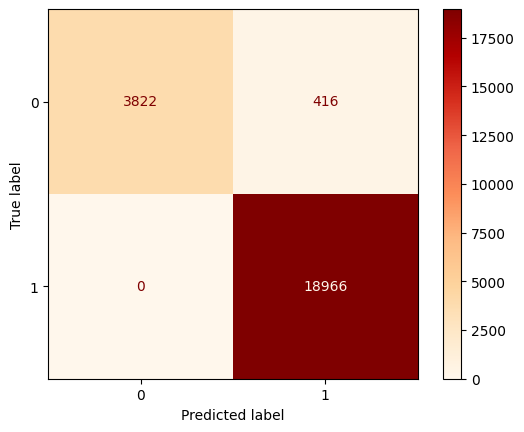

In [35]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_logit_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()

#### Linear Discriminant Analysis

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

logit = LinearDiscriminantAnalysis().fit(X_train,y_train)
y_lda_pred = logit.predict(X_test)

# Evaluate model
acc_score = accuracy_score(y_test, y_lda_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_lda_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_lda_pred)
print(f'Recall is {re}')

roc_auc = roc_auc_score(y_test, y_lda_pred)
print(f'ROC AUC is {roc_auc}')

Accuracy score is 0.9820720565419755
Precision is 0.9785367867093179
Recall is 1.0
ROC AUC is 0.9509202453987731


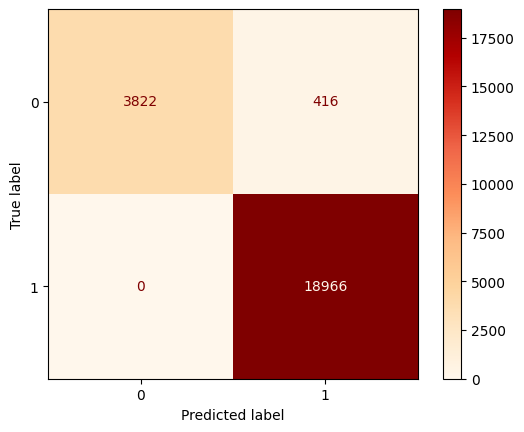

In [37]:
cm = confusion_matrix(y_test, y_lda_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()

#### Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

logit = GaussianNB().fit(X_train,y_train)
y_nb_pred = logit.predict(X_test)

# Evaluate model
acc_score = accuracy_score(y_test, y_nb_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_nb_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_nb_pred)
print(f'Recall is {re}')

roc_auc = roc_auc_score(y_test, y_nb_pred)
print(f'ROC AUC is {roc_auc}')

Accuracy score is 0.9814687122909843
Precision is 0.9785706909015801
Recall is 0.9992091110408099
ROC AUC is 0.9506427810985077


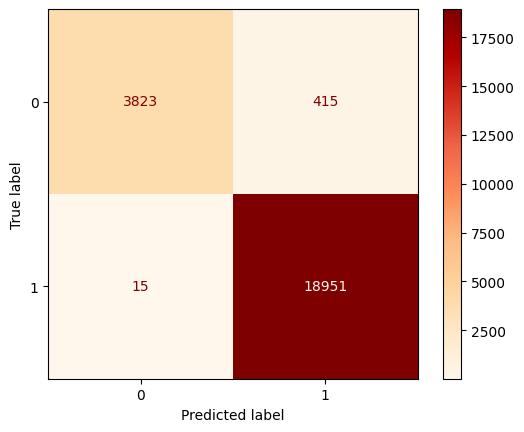

In [39]:
cm = confusion_matrix(y_test, y_nb_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()

#### Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=5,min_samples_split=0.3 ,random_state=0) # this way overfits the data
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=0.3, random_state=0)

Accuracy score is 0.9820720565419755
Precision is 0.9785367867093179
Recall is 1.0
ROC AUC is 0.9509202453987731


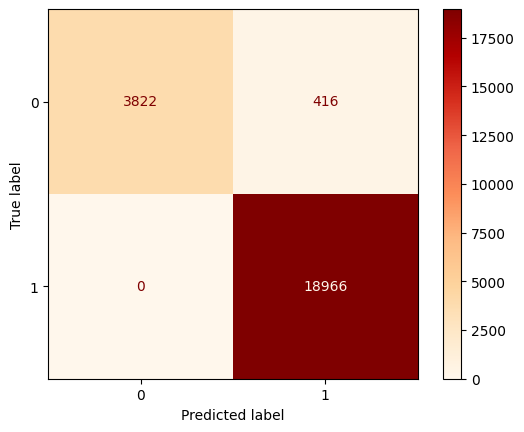

In [41]:
y_dtc_pred = dtc.predict(X_test)
acc_score = accuracy_score(y_test, y_dtc_pred)
print(f'Accuracy score is {acc_score}')

pr = precision_score(y_test, y_dtc_pred)
print(f'Precision is {pr}')

re = recall_score(y_test, y_dtc_pred)
print(f'Recall is {re}')

roc_auc = roc_auc_score(y_test, y_dtc_pred)
print(f'ROC AUC is {roc_auc}')

cm = confusion_matrix(y_test, y_dtc_pred)

cm_plot = ConfusionMatrixDisplay(cm)
cm_plot.plot(cmap="OrRd")
plt.show()


[Text(0.6, 0.8333333333333334, 't_in_last_3m <= 0.5\ngini = 0.296\nsamples = 92812\nvalue = [16737, 76075]'),
 Text(0.4, 0.5, 'FEDFUNDS <= 1.53\ngini = 0.037\nsamples = 77531\nvalue = [1456, 76075]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 61802\nvalue = [0, 61802]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.168\nsamples = 15729\nvalue = [1456, 14273]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 15281\nvalue = [15281, 0]')]

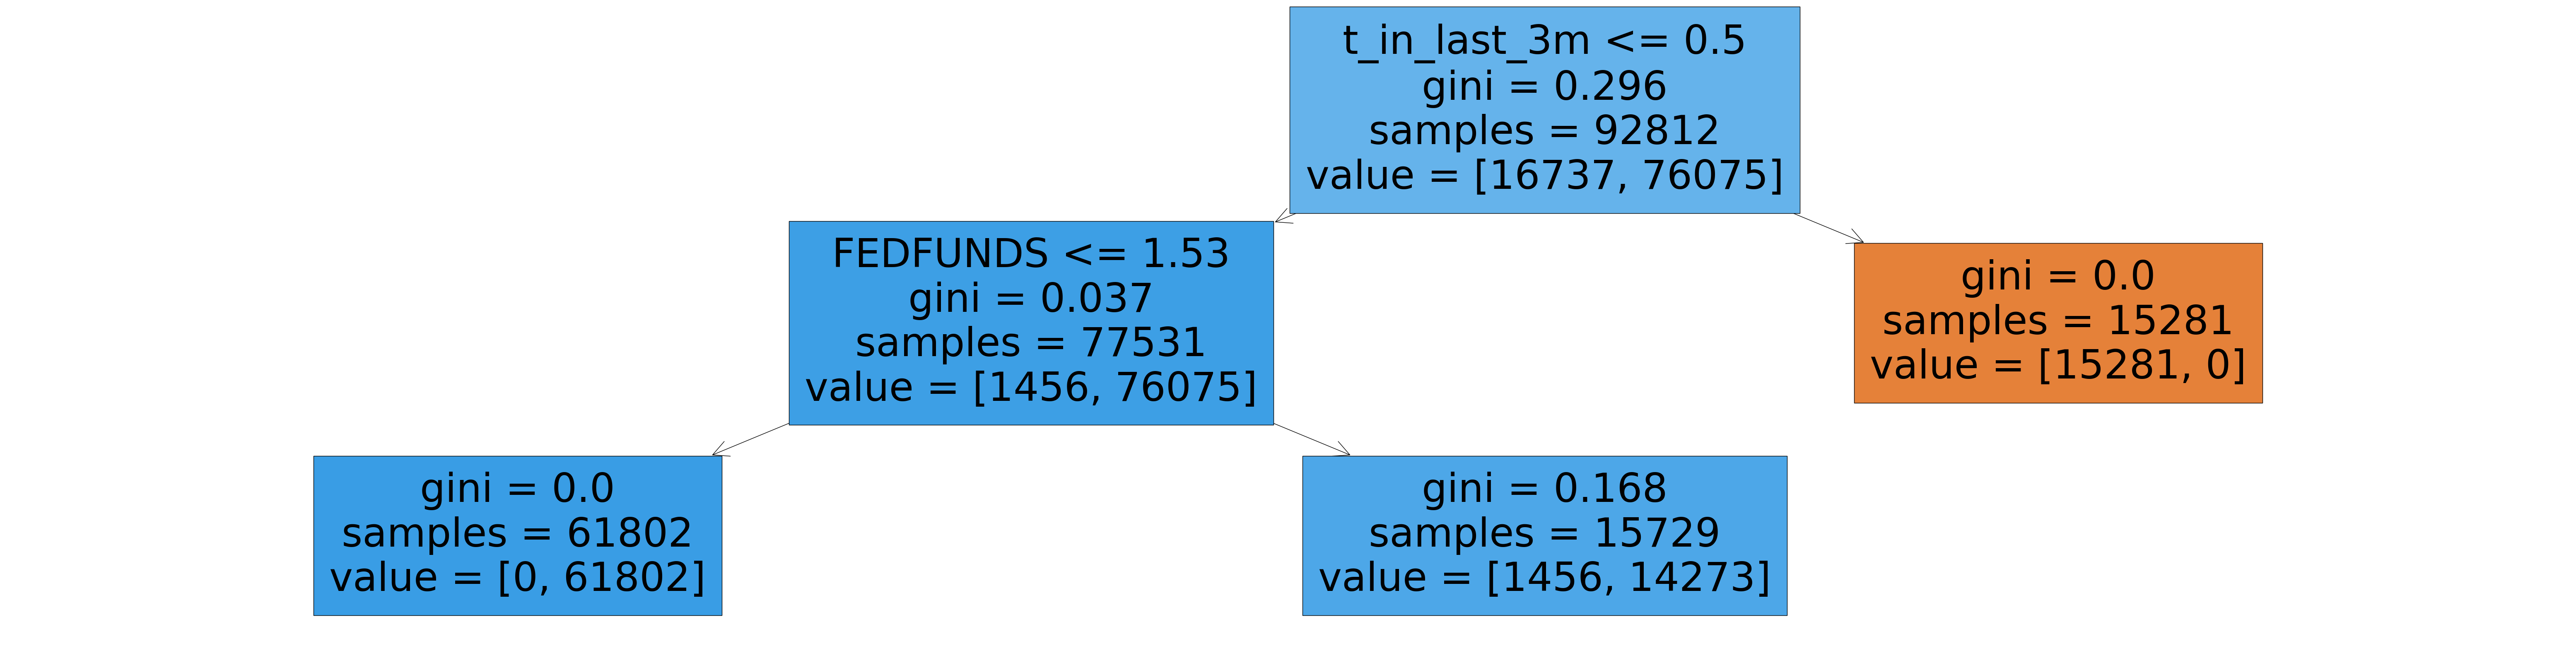

In [42]:
from sklearn.tree import plot_tree
plt.figure(figsize =(80,20))

plot_tree(dtc, feature_names=features, max_depth=2, filled=True)